# [G.D. 1] ResNet Ablation Study

### 목차
1. ResNet 기본 블록 구성하기
2. ResNet Complete Model
    1. ResNet-34
    2. ResNet-50
3. Plain Network 만들기
    1. Plain-34
    2. Plain-50
4. 데이터셋 준비하기
5. ResNet VS Plain Network
    1. Ablation Study
    2. 시각화
6. 회고

---

### 루브릭 평가 기준
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
    * 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
    * cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?
    * ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

## 1. RseNet 기본 블록 구성하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def conv_block(input_layer,
              channel,
              kernel_size,
              strides=1,
              activation='relu'):
    x = keras.layers.Conv2D(filters=channel,
                           kernel_size=kernel_size,
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(1e-4),
                           padding='same',
                           strides=strides)(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
        
    return x

In [4]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                   num_cnn=3,
                   channel=64,
                   block_num=0,
                   is_50=True):
    
    # 입력 레이어
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    return x

In [5]:
def build_resnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10,
                is_50=True,
                activation='softmax',
                name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x,
                              num_cnn=num_cnn,
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes,
                            activation=activation,
                            kernel_initializer='he_normal')(x)
        
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
        
    return model

## 2. ResNet Complete Model
### 2.1 ResNet-34

In [6]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')

resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

### 2.2 ResNet-50

In [7]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)

resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

## 3. Plain Network 만들기

In [8]:
def build_plain_block(input_layer,
                     num_cnn=3,
                     channel=64,
                     block_num=0,
                     is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
                
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))
    
    return x

In [9]:
def build_plainnet(input_shape=(32,32,3),
                  num_cnn_list=[3,4,6,3],
                  channel_list=[64,128,256,512],
                  num_classes=10,
                  is_50=True,
                  activation='softmax',
                  name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x,
                             num_cnn=num_cnn,
                             channel=channel,
                             block_num=block_num,
                             is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes,
                          activation=activation,
                          kernel_initializer='he_normal')(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 3.1 Plain-34

In [10]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')

plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

### 3.2 Plain-50

In [11]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

In [12]:
del resnet_34
del resnet_50
del plain_34
del plain_50

## 4. 데이터셋 준비하기

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [14]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [15]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [16]:
ds_info.features["label"].num_classes

2

In [17]:
ds_info.features["label"].names

['cat', 'dog']

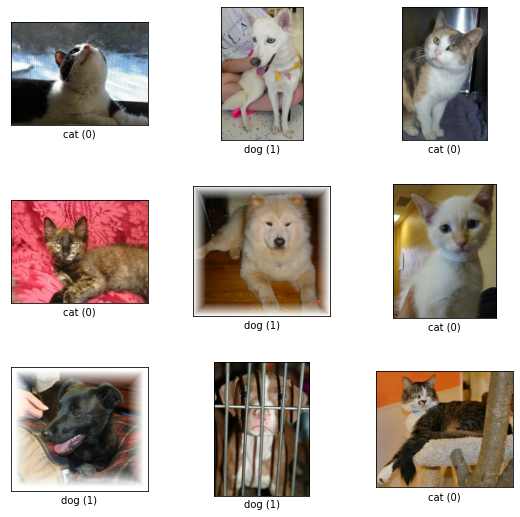

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

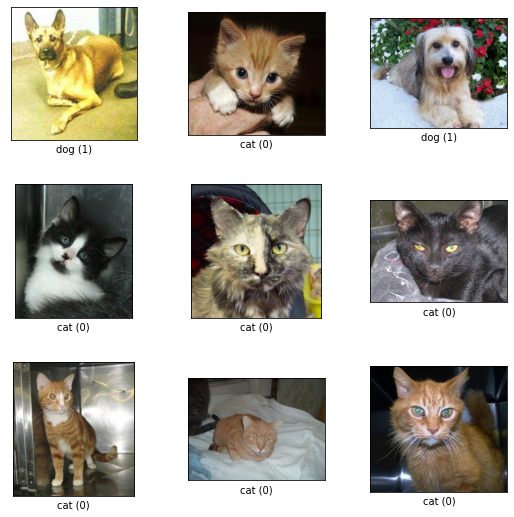

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

In [20]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [21]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 5. ResNet VS Plain Network

In [22]:
BATCH_SIZE = 16
EPOCH = 10

In [23]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test,batch_size=BATCH_SIZE)

### 5.1 Ablation Study
### ResNet-34

In [24]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

In [25]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 308s 246ms/step - loss: 2.1543 - accuracy: 0.5791 - val_loss: 1.2107 - val_accuracy: 0.5407
Epoch 2/10
1163/1163 [==============================] - 278s 239ms/step - loss: 1.0158 - accuracy: 0.6081 - val_loss: 0.7979 - val_accuracy: 0.6214
Epoch 3/10
1163/1163 [==============================] - 274s 235ms/step - loss: 0.7810 - accuracy: 0.6254 - val_loss: 0.9271 - val_accuracy: 0.4879
Epoch 4/10
1163/1163 [==============================] - 274s 236ms/step - loss: 0.7307 - accuracy: 0.6162 - val_loss: 1.0036 - val_accuracy: 0.4823
Epoch 5/10
1163/1163 [==============================] - 274s 236ms/step - loss: 0.6705 - accuracy: 0.6776 - val_loss: 2.0704 - val_accuracy: 0.5244
Epoch 6/10
1163/1163 [==============================] - 274s 236ms/step - loss: 0.6575 - accuracy: 0.7024 - val_loss: 0.8515 - val_accuracy: 0.5060
Epoch 7/10
1163/1163 [==============================] - 275s 236ms/step - loss: 0.5942 - accuracy: 0.7461 - val_

In [26]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('./data/history_resnet_34.csv', index=False)

### ResNet-50

In [27]:
resnet_50 = build_resnet(input_shape=(224,224,3),
                        num_classes=1,
                        is_50=True,
                        activation='sigmoid')

In [28]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 286s 212ms/step - loss: 5.2130 - accuracy: 0.5758 - val_loss: 2.4468 - val_accuracy: 0.6819
Epoch 2/10
1163/1163 [==============================] - 228s 196ms/step - loss: 2.1025 - accuracy: 0.6751 - val_loss: 3.4656 - val_accuracy: 0.5106
Epoch 3/10
1163/1163 [==============================] - 216s 186ms/step - loss: 1.3234 - accuracy: 0.7014 - val_loss: 1.0904 - val_accuracy: 0.6914
Epoch 4/10
1163/1163 [==============================] - 216s 186ms/step - loss: 0.9436 - accuracy: 0.7595 - val_loss: 2.6664 - val_accuracy: 0.5591
Epoch 5/10
1163/1163 [==============================] - 216s 186ms/step - loss: 0.7870 - accuracy: 0.7848 - val_loss: 1.1759 - val_accuracy: 0.6467
Epoch 6/10
1163/1163 [==============================] - 216s 186ms/step - loss: 0.7538 - accuracy: 0.7881 - val_loss: 0.7728 - val_accuracy: 0.7306
Epoch 7/10
1163/1163 [==============================] - 216s 186ms/step - loss: 0.6384 - accuracy: 0.8276 - val_

In [29]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
})
df_resnet_50.to_csv('./data/history_resnet_50.csv', index=False)

### Plain-34

In [30]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [31]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 271s 227ms/step - loss: 1.9130 - accuracy: 0.5313 - val_loss: 2.4240 - val_accuracy: 0.4914
Epoch 2/10
1163/1163 [==============================] - 263s 226ms/step - loss: 1.1077 - accuracy: 0.5056 - val_loss: 0.9306 - val_accuracy: 0.4953
Epoch 3/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.9339 - accuracy: 0.5019 - val_loss: 2.1623 - val_accuracy: 0.4881
Epoch 4/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.8549 - accuracy: 0.5093 - val_loss: 0.8075 - val_accuracy: 0.4810
Epoch 5/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.8275 - accuracy: 0.5278 - val_loss: 0.7543 - val_accuracy: 0.4890
Epoch 6/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.7766 - accuracy: 0.5022 - val_loss: 0.7507 - val_accuracy: 0.4849
Epoch 7/10
1163/1163 [==============================] - 263s 226ms/step - loss: 0.7522 - accuracy: 0.5019 - val_

In [32]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('./data/history_plain_34.csv', index=False)

### Plain-50

In [33]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

In [34]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 442s 359ms/step - loss: 3.9844 - accuracy: 0.5024 - val_loss: 2.0609 - val_accuracy: 0.4868
Epoch 2/10
1163/1163 [==============================] - 394s 339ms/step - loss: 1.8827 - accuracy: 0.5144 - val_loss: 1.6030 - val_accuracy: 0.5063
Epoch 3/10
1163/1163 [==============================] - 393s 338ms/step - loss: 1.4517 - accuracy: 0.4916 - val_loss: 1.2748 - val_accuracy: 0.4812
Epoch 4/10
1163/1163 [==============================] - 394s 338ms/step - loss: 1.2261 - accuracy: 0.4964 - val_loss: 5.9635 - val_accuracy: 0.5134
Epoch 5/10
1163/1163 [==============================] - 393s 338ms/step - loss: 1.0719 - accuracy: 0.5103 - val_loss: 1572.0289 - val_accuracy: 0.4881
Epoch 6/10
1163/1163 [==============================] - 394s 339ms/step - loss: 1.0270 - accuracy: 0.5126 - val_loss: 0.9456 - val_accuracy: 0.4853
Epoch 7/10
1163/1163 [==============================] - 394s 339ms/step - loss: 0.9686 - accuracy: 0.5101 - v

In [35]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('./data/history_plain_50.csv', index=False)

### 5.2 시각화

In [36]:
history_resnet_34 = pd.read_csv('./data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('./data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('./data/history_plain_34.csv')
history_plain_50 = pd.read_csv('./data/history_plain_50.csv')

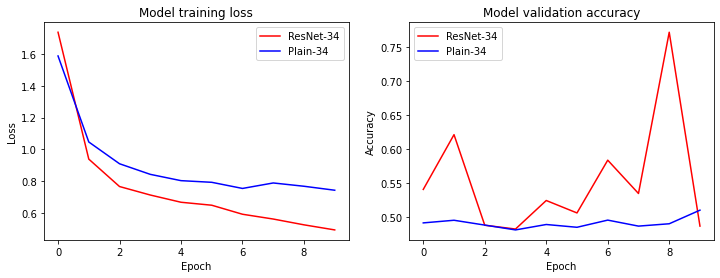

In [37]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

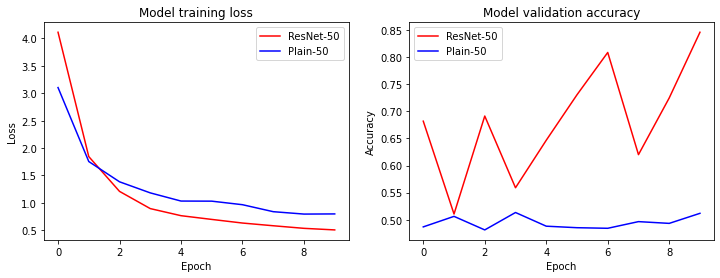

In [38]:
# ResNet-50 vs Plain-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

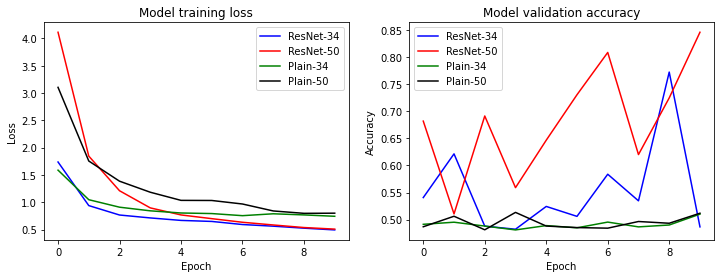

In [39]:
# 전체 비교
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

In [40]:
# validation accuracy 비교표
accuracy = {
    'Plain': [round(history_plain_34['val_acc'].mean(), 4),
              round(history_plain_50['val_acc'].mean(), 4)],
    'ResNet': [round(history_resnet_34['val_acc'].mean(), 4), 
               round(history_resnet_50['val_acc'].mean(), 4)]
}

df_acc = pd.DataFrame(accuracy, index=['34 layers', '50 layers'])
df_acc

,Plain,ResNet
34 layers,0.4912,0.554
50 layers,0.4947,0.682


## 6. 회고